In [23]:
#!/usr/bin/python3
from binance.client import Client
from time import time
import pickle as pickle
from datetime import datetime
import pandas as pd
import pandas_ta as ta
from pycaret.classification import load_model, predict_model
from pycaret.classification import *
from pycaret.classification import ClassificationExperiment
from lightgbm import LGBMClassifier
import numpy as np
import random


def get_client():
    fn = '../../key/binance-key.pickle'
    with open(fn, 'rb') as handle:
        k = pickle.load(handle)
    return Client(k['API_KEY'], k['API_SECRET'])


client = get_client()


def get_unix_timestamp(date_string):
    """
    Converts the input date string to Unix timestamp.

    Parameters:
        date_string (str): Input date string in the format "dd/mm/yyyy hh:mm:ss".

    Returns:
        int: Unix timestamp of the given date.
    """
    try:
        date_obj = datetime.strptime(date_string, "%d/%m/%Y %H:%M:%S")
        timestamp = int(date_obj.timestamp())
        return timestamp
    except ValueError:
        print("Invalid date format. Please use the format 'dd/mm/yyyy hh:mm:ss'.")
        return None

def get_historical_data(start_timestamp, end_timestamp, coin_pair): 
    data = []
    tot = (end_timestamp - start_timestamp)/(900*500)
    cntr = 0
    for current_sts in range(start_timestamp, end_timestamp+1, 900*500):
        next_ets = current_sts + 900*500 if (current_sts + 900*500) < end_timestamp else end_timestamp
        print(current_sts, next_ets, f'100% completed') if next_ets == end_timestamp else print(current_sts, next_ets, f'{round(cntr*100/tot, 1)}% completed')
        cntr += 1
        # Futures market
        klines = client.futures_historical_klines(coin_pair, '15m', current_sts*1000, next_ets*1000, limit=500)
        # Spot market
        # klines = client.get_historical_klines(coin_pair, interval, current_sts*1000, next_ets*1000, limit=500)
        
        for kline in klines:
            timestamp = kline[0]/1000
            open_price = float(kline[1])
            high_price = float(kline[2])
            low_price = float(kline[3])
            close_price = float(kline[4])
            volume = float(kline[5])

            data.append([timestamp, open_price, high_price, low_price, close_price, volume])

    df = pd.DataFrame(data, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
    df.to_csv(f'../../data/{coin_pair}-ohlcv.csv', index=False)
    # print('Data Exported')
    print(f'Historical Data of {coin_pair} Downloaded')
    return df


TypeError: 'list' object is not callable

Download Historical Data

In [14]:
# coins_list = ['BTC', 'ETH', 'BNB', 'XRP', 'ADA', 'DOGE', 'SOL', 'TRX', 'DOT', 'MATIC', 'LTC', 'BCH', 'AVAX', 'XLM', 'LINK', 'UNI', 'XMR', 'ATOM', 'ETC', 'HBAR', 'ICP', 'FIL', 'LDO', 'APT', 'ARB', 'QNT', 'VET', 'NEAR', 'OP', 'MKR', 'GRT', 'AAVE', 'ALGO', 'AXS', 'EGLD', 'STX', 'SAND', 'XTZ', 'EOS', 'INJ', 'THETA', 'IMX', 'SNX', 'MANA', 'FTM', 'RUNE', 'APE', 'RNDR', 'NEO', 'KAVA', 'FLOW', 'CHZ', 'GALA', 'KLAY', 'SUI', 'FXS', 'ZEC', 'CFX', 'CRV', 'MINA', 'COMP', 'GMX', 'DYDX', 'WOO', 'ASTR']
coins_list = ['ETH']
for i in range(len(coins_list)):
    coin_pair = f'{coins_list[i]}USDT'
    print('working on', coin_pair)
    # start_timestamp = get_unix_timestamp('1/1/2016 00:00:00')
    start_timestamp = get_unix_timestamp('1/1/2022 00:00:00')
    end_timestamp = get_unix_timestamp('1/6/2022 00:00:00')
    get_historical_data(start_timestamp, end_timestamp, coin_pair)

working on ETHUSDT
1640980800 1641430800 0.0% completed
1641430800 1641880800 3.4% completed
1641880800 1642330800 6.9% completed
1642330800 1642780800 10.3% completed
1642780800 1643230800 13.8% completed
1643230800 1643680800 17.2% completed
1643680800 1644130800 20.7% completed
1644130800 1644580800 24.1% completed
1644580800 1645030800 27.6% completed
1645030800 1645480800 31.0% completed
1645480800 1645930800 34.5% completed
1645930800 1646380800 37.9% completed
1646380800 1646830800 41.4% completed
1646830800 1647280800 44.8% completed
1647280800 1647730800 48.3% completed
1647730800 1648180800 51.7% completed
1648180800 1648630800 55.2% completed
1648630800 1649080800 58.6% completed
1649080800 1649530800 62.1% completed
1649530800 1649980800 65.5% completed
1649980800 1650430800 69.0% completed
1650430800 1650880800 72.4% completed
1650880800 1651330800 75.9% completed
1651330800 1651780800 79.3% completed
1651780800 1652230800 82.8% completed
1652230800 1652680800 86.2% comple

In [15]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import random


ohlc_df = pd.read_csv('../../data/ETHUSDT-ohlcv.csv')
ohlc_df['LOGRET_1'] = list(ohlc_df.ta.log_return())
ohlc_df['NATR_14'] = ohlc_df.ta.natr()
ohlc_df['SLOPE_1'] = ohlc_df.ta.slope()
bbands = ohlc_df.ta.bbands()
ohlc_df['BBB_5_2.0'] = list(bbands['BBB_5_2.0'])
ohlc_df['BBP_5_2.0'] = list(bbands['BBP_5_2.0'])
ohlc_df['PGO_14'] = list(ohlc_df.ta.pgo())
eri = ohlc_df.ta.eri()
ohlc_df['BEARP_13'] = list(eri['BEARP_13'])
ohlc_df['BULLP_13'] = list(eri['BULLP_13'])
ohlc_df['EFI_13'] = ohlc_df.ta.efi()
adx = ohlc_df.ta.adx()
ohlc_df['DMP_14'] = list(adx['DMP_14'])
ohlc_df['DMN_14'] = list(adx['DMN_14'])
ohlc_df['CG_10'] = ohlc_df.ta.cg()
trix = ohlc_df.ta.trix()
ohlc_df['TRIX_30_9'] = trix['TRIX_30_9']
ohlc_df['TRIXs_30_9'] = trix['TRIXs_30_9']
smi = ohlc_df.ta.smi()
ohlc_df['SMI_5_20_5'] = smi['SMI_5_20_5']
ohlc_df['SMIs_5_20_5'] = smi['SMIs_5_20_5']
ohlc_df['SMIo_5_20_5'] = smi['SMIo_5_20_5']
ohlc_df['AD'] = ohlc_df.ta.ad()
ohlc_df['TRUERANGE_1'] = ohlc_df.ta.true_range()
ohlc_df['PVT'] = ohlc_df.ta.pvt()
ohlc_df['EBSW_40_10'] = ohlc_df.ta.ebsw()
ohlc_df['PVOL'] = ohlc_df.ta.pvol()
thermo = ohlc_df.ta.thermo()
ohlc_df['THERMO_20_2_0.5'] = thermo['THERMO_20_2_0.5']
ohlc_df['THERMOma_20_2_0.5'] = thermo['THERMOma_20_2_0.5']
ohlc_df['CHOP_14_1_100'] = ohlc_df.ta.chop()
ohlc_df['PVI_1'] = ohlc_df.ta.pvi()
ohlc_df['VHF_28'] = ohlc_df.ta.vhf()



df = ohlc_df

ts = list(df['time'])
open = list(df['open'])
high = list(df['high'])
low = list(df['low'])
close = list(df['close'])
volume = list(df['volume'])
tot = len(ts)
long_runup_lst = []
long_drawdown_lst = []
short_runup_lst = []
short_drawdown_lst = []
candlestick_frame = 12
pnl_threshold = 3

for idx in range(tot):
    if (idx >= candlestick_frame) and (idx <= tot - candlestick_frame):
        max_high = max(high[idx+1:idx+candlestick_frame])
        min_low = min(low[idx+1:idx+candlestick_frame])
        entry_price = open[idx+1]
        long_runup_lst.append(round((max_high*100/entry_price)-100, 6))
        long_drawdown_lst.append(round((min_low*100/entry_price)-100, 6))
        short_runup_lst.append(round((entry_price*100/min_low)-100, 6))
        short_drawdown_lst.append(round((entry_price*100/max_high)-100, 6))
    else:
        long_runup_lst.append(0)
        long_drawdown_lst.append(0)
        short_runup_lst.append(0)
        short_drawdown_lst.append(0)     


long=[]
short=[]
dont_trade=[]
signal = []

for idx in range(tot):
    if (idx >= candlestick_frame) and (idx <= tot - candlestick_frame):
        if long_runup_lst[idx] >= pnl_threshold:
            signal.append('long')
        elif short_runup_lst[idx] >= pnl_threshold:
            signal.append('short')
        else:
            signal.append('dont_trade')
    else:
        signal.append('dont_trade')

df['signal'] = signal

long_indices = df[df['signal'].str.contains('long', case=False)].index
short_indices = df[df['signal'].str.contains('short', case=False)].index
dont_trade_indices = list(df[df['signal'].str.contains('dont_trade', case=False)].index)
num_indices_to_pick  = len(dont_trade_indices) - min([len(long_indices), len(short_indices)])
random_indices = random.sample(dont_trade_indices, num_indices_to_pick)
df = df.drop(random_indices)

df.reset_index(drop=True, inplace=True)

df = df.drop(columns = ['time', 'open', 'high', 'low', 'close', 'volume'], axis=1)
df = df.dropna()
df

,LOGRET_1,NATR_14,SLOPE_1,BBB_5_2.0,BBP_5_2.0,PGO_14,BEARP_13,BULLP_13,EFI_13,DMP_14,...,TRUERANGE_1,PVT,EBSW_40_10,PVOL,THERMO_20_2_0.5,THERMOma_20_2_0.5,CHOP_14_1_100,PVI_1,VHF_28,signal
2,0.000430,0.357407,1.60,0.556667,0.451035,0.119395,-3.072599,12.047401,2293.617623,26.080436,...,15.12,5.097640e+04,-0.933703,3.467760e+07,12.64,8.639396,65.948438,1002.272304,0.231912,dont_trade
3,0.001359,0.418544,5.07,0.674062,0.463046,0.772215,1.707312,10.117312,25577.687300,17.867321,...,8.41,5.365656e+04,-0.032053,1.364572e+07,1.00,7.618304,52.554881,1002.461141,0.245068,dont_trade
4,0.001523,0.358117,5.72,0.816184,0.686983,0.383605,-0.067407,9.972593,9349.687996,27.084391,...,10.04,6.698862e+04,-0.812216,1.591680e+07,11.05,9.074076,55.472683,1003.418117,0.231350,dont_trade
5,-0.000203,0.285917,-0.76,0.234622,0.481338,-0.547517,-6.015635,-1.565635,-2735.014592,15.935649,...,4.45,6.481352e+04,-0.911354,8.392135e+06,4.07,5.622761,61.256964,1002.793311,0.187221,dont_trade
6,0.001508,0.338945,5.62,1.156421,0.400949,-1.212780,-19.654705,-8.284705,-51329.882892,12.630537,...,11.37,5.161932e+04,-0.986199,2.064435e+07,2.39,7.734271,47.480853,1002.032106,0.290627,dont_trade
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2583,0.000162,0.480511,0.32,0.377340,0.779717,-0.640805,-9.581931,-0.771931,-19858.350386,14.045362,...,8.81,-3.972899e+06,-0.789012,2.951646e+07,3.03,5.162936,46.533302,961.884063,0.335848,dont_trade
2584,-0.001386,0.467521,-2.73,0.443236,0.108133,-0.371565,-11.325322,-0.375322,-25720.511381,20.950592,...,10.95,-3.979909e+06,0.181210,4.969484e+07,14.31,6.045934,58.597580,961.763069,0.386422,dont_trade
2585,-0.019952,0.797494,-39.16,2.649771,0.085048,-2.883244,-33.656083,14.183917,-847774.980963,20.811468,...,47.84,-4.273809e+06,-0.326098,3.220126e+08,33.93,9.247717,44.689036,960.733778,0.304000,dont_trade
2586,0.003633,0.939837,7.16,2.386310,0.612757,1.002168,-5.142057,10.817943,61653.607051,29.146266,...,15.96,-4.141819e+06,0.947697,1.330712e+08,23.04,12.146661,51.480321,962.002510,0.215614,dont_trade


In [16]:
candlestick_frame = 12

tot = len(df)
dta_lst = []

columns = list(df.columns)[:-1]
columns.pop(0)
lst_columns = {}
y_tsfresh = []
y = list(df['signal'])
for c in columns:
    lst_columns[c] = list(df[c])
for id in range(candlestick_frame, tot, 1):
    y_tsfresh.append(y[id])
    app_id = id - candlestick_frame + 1
    for i in range(candlestick_frame):
        app = {}
        app['signal']=y[id]
        app['id'] = app_id
        app['time'] = i
        for c in columns:
            app[c] = lst_columns[c][id-i]
        dta_lst.append(app)

app_df = pd.DataFrame(dta_lst)
training_y = list(app_df['signal'])
app_df = app_df.drop(columns = ['signal'], axis=1)
app_df.to_csv('../../data/df.csv', index=False)
pd.DataFrame({'signal': y_tsfresh}).to_csv('../../data/y.csv', index=False)
app_df

,id,time,NATR_14,SLOPE_1,BBB_5_2.0,BBP_5_2.0,PGO_14,BEARP_13,BULLP_13,EFI_13,...,AD,TRUERANGE_1,PVT,EBSW_40_10,PVOL,THERMO_20_2_0.5,THERMOma_20_2_0.5,CHOP_14_1_100,PVI_1,VHF_28
0,1,0,0.316472,1.16,0.243976,0.860945,0.886862,6.859219,14.189219,22240.290391,...,-1.032053e+03,7.33,8.908667e+03,0.998698,1.948411e+07,4.39,7.038766,49.797381,1001.854240,0.335574
1,1,1,0.369040,-6.75,0.798866,0.665979,1.125670,9.539340,22.719340,34270.334193,...,-1.060177e+03,13.18,8.128510e+03,0.961268,4.573330e+07,9.71,7.611585,46.988911,1001.854240,0.297868
2,1,2,0.482999,4.02,0.353658,0.425125,-0.490807,-15.816284,-6.476284,-67330.043448,...,-5.672457e+03,9.34,5.786483e+04,0.898764,1.673589e+07,7.58,11.798422,48.055387,1001.849695,0.433986
3,1,3,0.586174,18.74,0.769383,0.984622,-1.203558,-32.561480,-3.371480,-113248.542054,...,5.394488e+03,29.19,5.950464e+04,-0.856797,6.135602e+07,9.49,13.494393,39.088119,1001.948365,0.417827
4,1,4,0.302571,-3.34,0.853937,0.716453,0.640486,5.547999,14.657999,11082.580674,...,2.729222e+04,9.11,1.215741e+05,0.802024,2.349662e+07,6.77,7.307115,54.471904,1003.599431,0.237180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30883,2574,7,0.762191,9.16,2.865199,0.785757,1.968461,5.583588,22.333588,274680.178688,...,-1.925384e+06,16.75,-4.165931e+06,0.990700,5.636511e+07,6.23,10.159308,41.665693,961.297512,0.363546
30884,2574,8,0.751057,-2.95,2.556303,0.764299,1.368742,5.627520,19.707520,276409.565423,...,-1.951792e+06,14.08,-4.179525e+06,0.767007,8.901026e+07,17.07,10.572920,40.377603,961.297512,0.340455
30885,2574,9,0.754049,20.56,2.173641,0.959392,1.778841,0.665440,39.455440,344986.494968,...,-1.973901e+06,38.79,-4.172589e+06,0.264886,2.117819e+08,33.88,9.889017,39.793970,961.297512,0.401845
30886,2574,10,0.569601,10.41,0.968577,0.630487,0.204262,-9.988654,9.191346,29799.919210,...,-1.983070e+06,19.18,-4.288650e+06,-0.783589,6.311406e+07,8.83,7.363650,57.422977,960.230391,0.369688


In [10]:
len(y)

14401

In [11]:
len(y_tsfresh)+12

14401

In [17]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
import pandas as pd

df = pd.read_csv('../../data/df.csv')
y = pd.read_csv('../../data/y.csv')

extraction_settings = ComprehensiveFCParameters()
chunk_size = 6000
chunks = [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]
tot = len(chunks)
for idx, chunk_df in enumerate(chunks):
    print(f'{tot - idx} remaining \t\t {round((idx*100/tot),1)}% done')
    X = extract_features(chunk_df, column_id='id', column_sort='time',
                        default_fc_parameters=extraction_settings,
                        # we impute = remove all NaN features automatically
                        impute_function=impute)
    X.to_csv(f'../../data/chunks/{idx}.csv', index=False)

6 remaining 		 0.0% done


Feature Extraction: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


5 remaining 		 16.7% done


Feature Extraction: 100%|██████████| 40/40 [01:46<00:00,  2.67s/it]


4 remaining 		 33.3% done


Feature Extraction: 100%|██████████| 40/40 [01:56<00:00,  2.92s/it]


3 remaining 		 50.0% done


Feature Extraction: 100%|██████████| 40/40 [02:46<00:00,  4.17s/it]


2 remaining 		 66.7% done


Feature Extraction: 100%|██████████| 40/40 [01:45<00:00,  2.63s/it]


1 remaining 		 83.3% done


Feature Extraction: 100%|██████████| 40/40 [00:16<00:00,  2.44it/s]


In [18]:
dfs=[]
dataset_path = '../../data/chunks/'

for i in range(len(chunks)):
    dfs.append(pd.read_csv(f'{dataset_path}{i}.csv'))

concatenated_df = pd.concat(dfs, ignore_index=True)  # Set ignore_index=True to reset index
pd.DataFrame(concatenated_df).to_csv(f'../../data/tsfresh_training_dataset.csv', index=False)


In [19]:
concatenated_df

,NATR_14__variance_larger_than_standard_deviation,NATR_14__has_duplicate_max,NATR_14__has_duplicate_min,NATR_14__has_duplicate,NATR_14__sum_values,NATR_14__abs_energy,NATR_14__mean_abs_change,NATR_14__mean_change,NATR_14__mean_second_derivative_central,NATR_14__median,...,VHF_28__fourier_entropy__bins_5,VHF_28__fourier_entropy__bins_10,VHF_28__fourier_entropy__bins_100,VHF_28__permutation_entropy__dimension_3__tau_1,VHF_28__permutation_entropy__dimension_4__tau_1,VHF_28__permutation_entropy__dimension_5__tau_1,VHF_28__permutation_entropy__dimension_6__tau_1,VHF_28__permutation_entropy__dimension_7__tau_1,VHF_28__query_similarity_count__query_None__threshold_0.0,VHF_28__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,4.342822,1.667957,0.085516,0.009279,0.000393,0.335508,...,1.277034,1.277034,1.945910,1.695743,2.197225,2.079442,1.94591,1.791759,0.0,0.325628
1,0.0,0.0,0.0,0.0,4.357613,1.680558,0.090647,-0.006838,0.009453,0.335508,...,1.153742,1.475076,1.945910,1.504788,2.043192,2.079442,1.94591,1.791759,0.0,0.365822
2,0.0,0.0,0.0,0.0,4.389897,1.704723,0.087986,-0.009499,-0.004798,0.335508,...,1.277034,1.277034,1.945910,1.366159,2.043192,2.079442,1.94591,1.791759,0.0,0.397713
3,0.0,0.0,0.0,0.0,4.703979,1.982973,0.102220,-0.023732,0.012831,0.353993,...,1.277034,1.277034,1.747868,1.504788,2.043192,2.079442,1.94591,1.791759,0.0,0.402983
4,0.0,0.0,0.0,0.0,4.780612,2.040794,0.114711,-0.011241,-0.011228,0.379720,...,1.153742,1.475076,1.747868,1.557113,2.043192,2.079442,1.94591,1.791759,0.0,0.402983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569,0.0,0.0,0.0,0.0,7.461094,4.907345,0.087488,0.001099,-0.014743,0.541032,...,1.277034,1.549826,1.747868,1.557113,2.197225,2.079442,1.94591,1.791759,0.0,0.426032
2570,0.0,0.0,0.0,0.0,7.436015,4.883266,0.086863,0.004086,0.001492,0.541032,...,1.078992,1.351784,1.747868,1.504788,2.043192,2.079442,1.94591,1.791759,0.0,0.428422
2571,0.0,0.0,0.0,0.0,7.721045,5.256644,0.112967,-0.029805,0.015743,0.660329,...,1.277034,1.475076,1.945910,1.279854,1.889159,2.079442,1.94591,1.791759,0.0,0.428422
2572,0.0,0.0,0.0,0.0,8.191248,5.919381,0.124534,-0.041373,0.006013,0.752553,...,1.277034,1.549826,1.945910,1.470808,2.043192,2.079442,1.94591,1.791759,0.0,0.426375


In [20]:
y = pd.read_csv('../../data/y.csv')
y

,signal
0,dont_trade
1,dont_trade
2,dont_trade
3,dont_trade
4,dont_trade
...,...
2569,dont_trade
2570,dont_trade
2571,dont_trade
2572,dont_trade


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


,Description,Value
0,Session id,123
1,Target,signal
2,Target type,Multiclass
3,Target mapping,"dont_trade: 0, long: 1, short: 2"
4,Original data shape,"(2574, 20359)"
5,Transformed data shape,"(2574, 20359)"
6,Transformed train set shape,"(1801, 20359)"
7,Transformed test set shape,"(773, 20359)"
8,Numeric features,20358
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8011,0.9381,0.8011,0.8061,0.8016,0.7002,0.7020
1,0.8333,0.9474,0.8333,0.8360,0.8335,0.7470,0.7480
2,0.7944,0.9297,0.7944,0.7962,0.7915,0.6854,0.6891
3,0.8556,0.9495,0.8556,0.8581,0.8546,0.7789,0.7812
4,0.8500,0.9528,0.8500,0.8522,0.8494,0.7713,0.7728
5,0.8667,0.9529,0.8667,0.8667,0.8665,0.7976,0.7978
6,0.8056,0.9335,0.8056,0.8114,0.8043,0.7028,0.7061
7,0.8667,0.9714,0.8667,0.8696,0.8664,0.7971,0.7985
8,0.8222,0.9532,0.8222,0.8238,0.8225,0.7305,0.7309


Transformation Pipeline and Model Successfully Saved


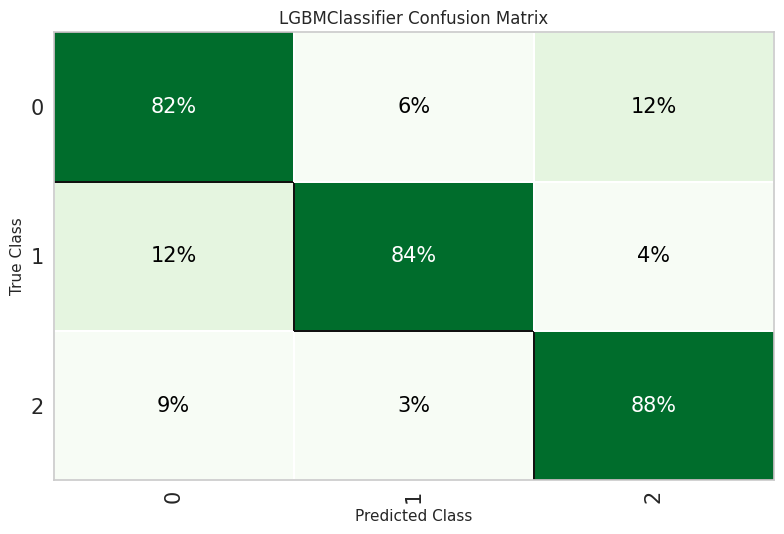

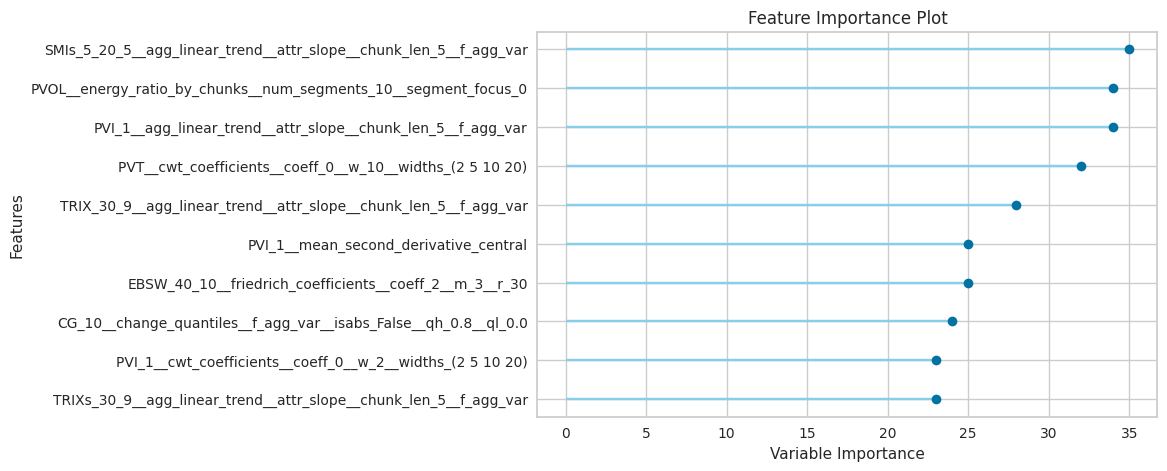

In [22]:
from pycaret.classification import load_model, predict_model
from pycaret.classification import *
from pycaret.classification import ClassificationExperiment
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd


exp = ClassificationExperiment()
dataset_path = '../../data/'
data = pd.read_csv('../../data/tsfresh_training_dataset.csv')

y = pd.read_csv('../../data/y.csv')
data['signal'] = list(y['signal'])
# data.replace([np.inf, -np.inf], np.nan, inplace=True)
s = setup(data, target = 'signal', session_id = 123, use_gpu=True)
model = create_model(LGBMClassifier())
# model = compare_models(exclude='gbc')
# validation_scores = pull()
# accuracy_mean = validation_scores['Accuracy']['Mean']

# save pipeline
model_name = 'tsfresh'
save_model(model, f'../../models/{model_name}')
# print(f'{model_name} model saved. accuracy_mean={accuracy_mean}')
plot_model(model, plot = 'confusion_matrix', plot_kwargs = {'percent': True})
plot_model(model, plot = 'feature')

In [1]:
import numpy as np
import pandas as pd


data = pd.read_csv('../../data/tsfresh_testing_dataset.csv')
data

,LOGRET_1__variance_larger_than_standard_deviation,LOGRET_1__has_duplicate_max,LOGRET_1__has_duplicate_min,LOGRET_1__has_duplicate,LOGRET_1__sum_values,LOGRET_1__abs_energy,LOGRET_1__mean_abs_change,LOGRET_1__mean_change,LOGRET_1__mean_second_derivative_central,LOGRET_1__median,...,VHF_28__fourier_entropy__bins_5,VHF_28__fourier_entropy__bins_10,VHF_28__fourier_entropy__bins_100,VHF_28__permutation_entropy__dimension_3__tau_1,VHF_28__permutation_entropy__dimension_4__tau_1,VHF_28__permutation_entropy__dimension_5__tau_1,VHF_28__permutation_entropy__dimension_6__tau_1,VHF_28__permutation_entropy__dimension_7__tau_1,VHF_28__query_similarity_count__query_None__threshold_0.0,VHF_28__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,-0.000324,0.000005,0.000791,-0.000022,0.000164,-0.000154,...,0.796312,0.796312,1.549826,1.220607,1.676988,2.079442,1.945910,1.791759,0.0,0.414968
1,0.0,0.0,0.0,0.0,-0.002614,0.000007,0.000880,0.000067,-0.000134,-0.000291,...,0.410116,0.955700,1.945910,0.950271,1.427061,1.906155,1.945910,1.791759,0.0,0.409198
2,0.0,0.0,0.0,0.0,-0.001549,0.000007,0.001031,-0.000083,0.000073,-0.000154,...,0.410116,0.955700,1.549826,0.950271,1.427061,1.667462,1.747868,1.791759,0.0,0.397697
3,0.0,0.0,0.0,0.0,-0.000891,0.000006,0.001023,-0.000029,-0.000092,-0.000096,...,0.410116,0.796312,1.549826,0.950271,1.149060,1.386294,1.475076,1.560710,0.0,0.386517
4,0.0,0.0,0.0,0.0,-0.000950,0.000006,0.000914,0.000149,0.000037,-0.000096,...,0.796312,0.796312,1.475076,0.801819,1.002718,1.073543,1.153742,1.242453,0.0,0.375433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14384,0.0,0.0,0.0,0.0,0.001762,0.000006,0.000707,0.000055,0.000136,0.000102,...,0.955700,1.475076,1.747868,1.220607,1.581094,1.667462,1.747868,1.791759,0.0,0.333386
14385,0.0,0.0,0.0,0.0,0.001251,0.000006,0.000550,-0.000119,-0.000055,0.000102,...,1.153742,1.475076,1.747868,1.088900,1.303092,1.386294,1.475076,1.560710,0.0,0.333895
14386,0.0,0.0,0.0,0.0,0.004470,0.000009,0.000614,-0.000184,0.000092,0.000132,...,0.796312,1.153742,1.747868,1.088900,1.303092,1.386294,1.475076,1.560710,0.0,0.333976
14387,0.0,0.0,0.0,0.0,0.001902,0.000015,0.001026,0.000239,-0.000275,0.000132,...,0.796312,0.796312,1.475076,1.088900,1.303092,1.386294,1.475076,1.560710,0.0,0.333847


In [4]:
signal = pd.read_csv('../../data/y.csv')['signal']
signal

0        dont_trade
1        dont_trade
2        dont_trade
3        dont_trade
4        dont_trade
            ...    
14384    dont_trade
14385    dont_trade
14386    dont_trade
14387    dont_trade
14388    dont_trade
Name: signal, Length: 14389, dtype: object

In [8]:
from pycaret.classification import load_model, predict_model


model = load_model('../../models/tsfresh')
predictions = predict_model(model, data=data)

Transformation Pipeline and Model Successfully Loaded


In [9]:
predictions

,LOGRET_1__variance_larger_than_standard_deviation,LOGRET_1__has_duplicate_max,LOGRET_1__has_duplicate_min,LOGRET_1__has_duplicate,LOGRET_1__sum_values,LOGRET_1__abs_energy,LOGRET_1__mean_abs_change,LOGRET_1__mean_change,LOGRET_1__mean_second_derivative_central,LOGRET_1__median,...,VHF_28__fourier_entropy__bins_100,VHF_28__permutation_entropy__dimension_3__tau_1,VHF_28__permutation_entropy__dimension_4__tau_1,VHF_28__permutation_entropy__dimension_5__tau_1,VHF_28__permutation_entropy__dimension_6__tau_1,VHF_28__permutation_entropy__dimension_7__tau_1,VHF_28__query_similarity_count__query_None__threshold_0.0,VHF_28__mean_n_absolute_max__number_of_maxima_7,prediction_label,prediction_score
0,0.0,0.0,0.0,0.0,-0.000324,0.000005,0.000791,-0.000022,0.000164,-0.000154,...,1.549826,1.220607,1.676988,2.079442,1.945910,1.791759,0.0,0.414968,dont_trade,0.9970
1,0.0,0.0,0.0,0.0,-0.002614,0.000007,0.000880,0.000067,-0.000134,-0.000291,...,1.945910,0.950271,1.427061,1.906155,1.945910,1.791759,0.0,0.409198,dont_trade,0.9972
2,0.0,0.0,0.0,0.0,-0.001549,0.000007,0.001031,-0.000083,0.000073,-0.000154,...,1.549826,0.950271,1.427061,1.667462,1.747868,1.791759,0.0,0.397697,dont_trade,0.9978
3,0.0,0.0,0.0,0.0,-0.000891,0.000006,0.001023,-0.000029,-0.000092,-0.000096,...,1.549826,0.950271,1.149060,1.386294,1.475076,1.560710,0.0,0.386517,dont_trade,0.9956
4,0.0,0.0,0.0,0.0,-0.000950,0.000006,0.000914,0.000149,0.000037,-0.000096,...,1.475076,0.801819,1.002718,1.073543,1.153742,1.242453,0.0,0.375433,dont_trade,0.9967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14384,0.0,0.0,0.0,0.0,0.001762,0.000006,0.000707,0.000055,0.000136,0.000102,...,1.747868,1.220607,1.581094,1.667462,1.747868,1.791759,0.0,0.333386,dont_trade,0.9983
14385,0.0,0.0,0.0,0.0,0.001251,0.000006,0.000550,-0.000119,-0.000055,0.000102,...,1.747868,1.088900,1.303092,1.386294,1.475076,1.560710,0.0,0.333895,dont_trade,0.9990
14386,0.0,0.0,0.0,0.0,0.004470,0.000009,0.000614,-0.000184,0.000092,0.000132,...,1.747868,1.088900,1.303092,1.386294,1.475076,1.560710,0.0,0.333976,dont_trade,0.9990
14387,0.0,0.0,0.0,0.0,0.001902,0.000015,0.001026,0.000239,-0.000275,0.000132,...,1.475076,1.088900,1.303092,1.386294,1.475076,1.560710,0.0,0.333847,dont_trade,0.9992


In [12]:
analyse = pd.DataFrame()
analyse['correct_sig'] = list(signal)
analyse['predicted_sig'] = predictions['prediction_label']
analyse['prediction_score'] = predictions['prediction_score']

analyse.to_csv('../../data/analyse.csv', index=False)
analyse

,correct_sig,predicted_sig,prediction_score
0,dont_trade,dont_trade,0.9970
1,dont_trade,dont_trade,0.9972
2,dont_trade,dont_trade,0.9978
3,dont_trade,dont_trade,0.9956
4,dont_trade,dont_trade,0.9967
...,...,...,...
14384,dont_trade,dont_trade,0.9983
14385,dont_trade,dont_trade,0.9990
14386,dont_trade,dont_trade,0.9990
14387,dont_trade,dont_trade,0.9992
